In [11]:
import numpy as np
import os
import cv2 as cv
from sklearn.model_selection import train_test_split
import tensorflow as tf
real_data = "SOCOFing/Real"
altered_data = "SOCOFing/Altered"

Sokoto Coventry Fingerprint Dataset (SOCOFing) is a biometric fingerprint database designed for academic research purposes. SOCOFing is made up of 6,000 fingerprint images from 600 African subjects and contains unique attributes such as labels for gender, hand and finger name as well as synthetically altered versions with three different levels of alteration for obliteration, central rotation, and z-cut. For a complete formal description and usage policy please refer to the following paper: https://arxiv.org/abs/1807.10609

In [2]:
data = []
labels = []

# load the real data and their labels
photos_names = os.listdir(real_data)
for name in photos_names:
    data.append(cv.imread(os.path.join(real_data ,name) ,cv.IMREAD_GRAYSCALE))
    labels.append(0)

# load the altered data and their labels
dirs = ["Altered-Easy" ,"Altered-Hard" ,"Altered-Medium"]
for folder in dirs:
    photos_names = os.listdir(os.path.join(altered_data ,folder))
    for name in photos_names:
        data.append(cv.imread(os.path.join(altered_data ,folder ,name) ,cv.IMREAD_GRAYSCALE))
        labels.append(1)

In [3]:
x = 96
y = 103

In [4]:
# resizeing all the data to 103X96
for i,image in enumerate(data):
    data[i] = cv.resize(image ,(x,y))
    
data = np.stack(data).reshape(-1 ,y ,x ,1)
labels = np.stack(labels).reshape(-1 ,1)

In [5]:
train_data, test_data, train_labels, test_labels  = train_test_split(data, labels, test_size=0.2, random_state=42)

In [6]:
# print the shape of the data for each image
i = 0
for image in train_data:
    if image.shape != (y, x, 1):
        i += 1
print('images without the correct shape: ', i)

images without the correct shape:  0


[1]


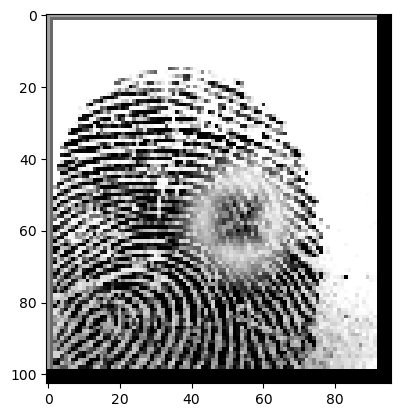

In [ ]:
# visualization of 1 image from train data
import matplotlib.pyplot as plt
print(train_labels[0])
plt.imshow(train_data[0], cmap='gray')
plt.show()

In [7]:
# converting numpy arrays to tensors
train_data_tensor = tf.convert_to_tensor(train_data, dtype=tf.float16)
test_data_tensor = tf.convert_to_tensor(test_data, dtype=tf.float16)
train_labels_tensor = tf.convert_to_tensor(train_labels, dtype=tf.int16)
test_labels_tensor = tf.convert_to_tensor(test_labels, dtype=tf.int16)

# converting to 3 channels
train_data_3 = tf.image.grayscale_to_rgb(train_data_tensor)
test_data_3 = tf.image.grayscale_to_rgb(test_data_tensor)

### Using Cross Entropy loss

In [7]:
from keras.applications.resnet import ResNet50
from keras.models import Model
from keras.layers import Flatten, Dense
from sklearn.metrics import balanced_accuracy_score
from sklearn.metrics import confusion_matrix
from sklearn.metrics import classification_report

base_model = ResNet50(include_top=False, weights='imagenet', input_shape=(y, x, 3))
for layer in base_model.layers:
    layer.trainable = False
    
x = base_model.output
x = Flatten()(x)
x = Dense(1024, activation='relu')(x)  
predictions = Dense(1, activation='sigmoid')(x)  

# Creating model combining the base of ResNet50 and the new custom layers
model = Model(inputs=base_model.input, outputs=predictions)

# Visualizing the network architecture
# model.summary()

model.compile(optimizer='adam', loss="binary_crossentropy", metrics=["accuracy"])
history = model.fit(train_data_3, train_labels_tensor, epochs=10, batch_size=32, validation_split=0.2)



Epoch 1/10
1106/1106 [==============================] - 45s 37ms/step - loss: 0.5330 - accuracy: 0.8981 - val_loss: 0.1879 - val_accuracy: 0.9160
Epoch 2/10
1106/1106 [==============================] - 39s 36ms/step - loss: 0.1714 - accuracy: 0.9214 - val_loss: 0.2175 - val_accuracy: 0.9064
Epoch 3/10
1106/1106 [==============================] - 39s 36ms/step - loss: 0.1646 - accuracy: 0.9257 - val_loss: 0.1737 - val_accuracy: 0.9196
Epoch 4/10
1106/1106 [==============================] - 39s 36ms/step - loss: 0.1596 - accuracy: 0.9287 - val_loss: 0.2252 - val_accuracy: 0.9034
Epoch 5/10
1106/1106 [==============================] - 39s 36ms/step - loss: 0.1506 - accuracy: 0.9319 - val_loss: 0.1808 - val_accuracy: 0.9178
Epoch 6/10
1106/1106 [==============================] - 39s 36ms/step - loss: 0.1452 - accuracy: 0.9349 - val_loss: 0.1836 - val_accuracy: 0.9159
Epoch 7/10
1106/1106 [==============================] - 39s 36ms/step - loss: 0.1364 - accuracy: 0.9381 - val_loss: 0.2071 -

In [8]:
y_pred = model.predict(test_data_3)


print("Balanced Accuracy: " +  str(balanced_accuracy_score(test_labels_tensor, np.rint(y_pred))))
print("Confusion Matrix: \n" +  str(confusion_matrix(test_labels_tensor, np.rint(y_pred))))
print(classification_report(test_labels_tensor, np.rint(y_pred)))

346/346 [==============================] - 9s 25ms/step
Balanced Accuracy: 0.7971014516878652
Confusion Matrix: 
[[ 790  432]
 [ 514 9318]]
              precision    recall  f1-score   support

           0       0.61      0.65      0.63      1222
           1       0.96      0.95      0.95      9832

    accuracy                           0.91     11054
   macro avg       0.78      0.80      0.79     11054
weighted avg       0.92      0.91      0.92     11054



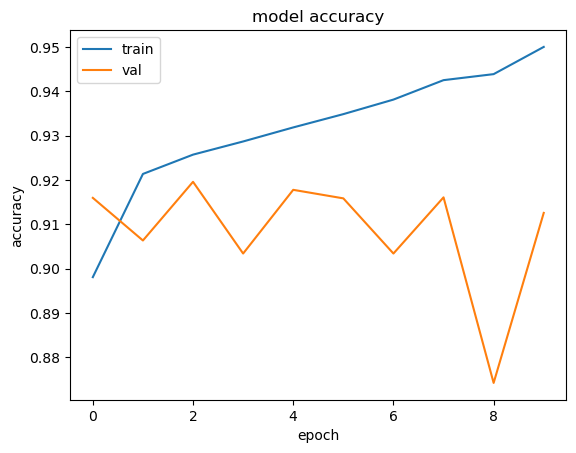

In [9]:
from matplotlib import pyplot as plt

plt.plot(history.history['accuracy'])
plt.plot(history.history['val_accuracy'])
plt.title('model accuracy')
plt.ylabel('accuracy')
plt.xlabel('epoch')
plt.legend(['train', 'val'], loc='upper left')
plt.show()

### Using Binary Accuracy metric

In [7]:
from keras.applications.resnet import ResNet50
from keras.models import Model
from keras.layers import Flatten, Dense
from sklearn.metrics import balanced_accuracy_score
from sklearn.metrics import confusion_matrix
from sklearn.metrics import classification_report

base_model = ResNet50(include_top=False, weights='imagenet', input_shape=(y, x, 3))
for layer in base_model.layers:
    layer.trainable = False
    
x = base_model.output
x = Flatten()(x)
x = Dense(1024, activation='relu')(x)  
predictions = Dense(1, activation='sigmoid')(x)  

# Creating model combining the base of ResNet50 and the new custom layers
model = Model(inputs=base_model.input, outputs=predictions)

# Visualizing the network architecture
# model.summary()

tf.keras.metrics.BinaryAccuracy(
    name="binary_accuracy", dtype=None, threshold=0.5
)

model.compile(optimizer='adam', loss="binary_crossentropy", metrics=[tf.keras.metrics.BinaryAccuracy()])
history = model.fit(train_data_3, train_labels_tensor, epochs=10, batch_size=32, validation_split=0.2)


Epoch 1/10
1106/1106 [==============================] - 46s 38ms/step - loss: 0.6161 - binary_accuracy: 0.8952 - val_loss: 0.1948 - val_binary_accuracy: 0.9091
Epoch 2/10
1106/1106 [==============================] - 40s 37ms/step - loss: 0.1736 - binary_accuracy: 0.9200 - val_loss: 0.1735 - val_binary_accuracy: 0.9166
Epoch 3/10
1106/1106 [==============================] - 41s 37ms/step - loss: 0.1645 - binary_accuracy: 0.9257 - val_loss: 0.1972 - val_binary_accuracy: 0.9108
Epoch 4/10
1106/1106 [==============================] - 41s 37ms/step - loss: 0.1579 - binary_accuracy: 0.9284 - val_loss: 0.1905 - val_binary_accuracy: 0.9114
Epoch 5/10
1106/1106 [==============================] - 41s 37ms/step - loss: 0.1562 - binary_accuracy: 0.9288 - val_loss: 0.1794 - val_binary_accuracy: 0.9151
Epoch 6/10
1106/1106 [==============================] - 40s 36ms/step - loss: 0.1459 - binary_accuracy: 0.9337 - val_loss: 0.1736 - val_binary_accuracy: 0.9199
Epoch 7/10
1106/1106 [==================

In [8]:
y_pred = model.predict(test_data_3)


print("Balanced Accuracy: " +  str(balanced_accuracy_score(test_labels_tensor, np.rint(y_pred))))
print("Confusion Matrix: \n" +  str(confusion_matrix(test_labels_tensor, np.rint(y_pred))))
print(classification_report(test_labels_tensor, np.rint(y_pred)))

346/346 [==============================] - 9s 25ms/step
Balanced Accuracy: 0.8540084716194423
Confusion Matrix: 
[[ 965  257]
 [ 803 9029]]
              precision    recall  f1-score   support

           0       0.55      0.79      0.65      1222
           1       0.97      0.92      0.94      9832

    accuracy                           0.90     11054
   macro avg       0.76      0.85      0.80     11054
weighted avg       0.93      0.90      0.91     11054



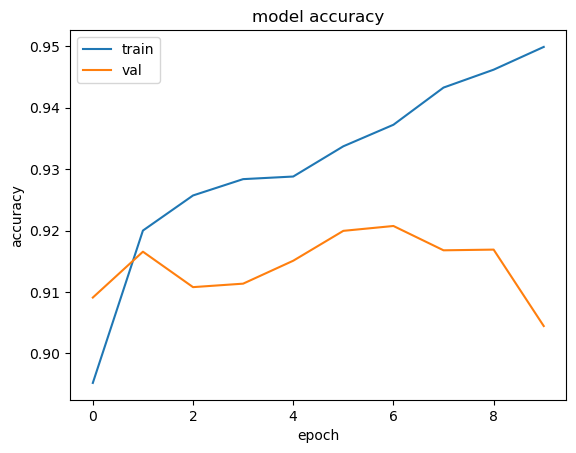

In [9]:
from matplotlib import pyplot as plt

plt.plot(history.history['binary_accuracy'])
plt.plot(history.history['val_binary_accuracy'])
plt.title('model accuracy')
plt.ylabel('accuracy')
plt.xlabel('epoch')
plt.legend(['train', 'val'], loc='upper left')
plt.show()

### Using Image Random Flip

In [8]:
from keras.applications.resnet import ResNet50
from keras.models import Model
from keras.layers import Flatten, Dense, RandomFlip
from sklearn.metrics import balanced_accuracy_score
from sklearn.metrics import confusion_matrix
from sklearn.metrics import classification_report

base_model = ResNet50(include_top=False, weights='imagenet', input_shape=(y, x, 3))
for layer in base_model.layers:
    layer.trainable = False
    
x = base_model.output
x = RandomFlip("horizontal")(x)
x = Flatten()(x)
x = Dense(1024, activation='relu')(x)  
predictions = Dense(1, activation='sigmoid')(x)  

# Creating model combining the base of ResNet50 and the new custom layers
model = Model(inputs=base_model.input, outputs=predictions)

# Visualizing the network architecture
# model.summary()

tf.keras.metrics.BinaryAccuracy(
    name="binary_accuracy", dtype=None, threshold=0.5
)

model.compile(optimizer='adam', loss="binary_crossentropy", metrics=[tf.keras.metrics.BinaryAccuracy()])
history = model.fit(train_data_3, train_labels_tensor, epochs=10, batch_size=32, validation_split=0.2)

Epoch 1/10
1106/1106 [==============================] - 55s 45ms/step - loss: 0.5225 - binary_accuracy: 0.9005 - val_loss: 0.2595 - val_binary_accuracy: 0.8942
Epoch 2/10
1106/1106 [==============================] - 49s 44ms/step - loss: 0.1741 - binary_accuracy: 0.9188 - val_loss: 0.1978 - val_binary_accuracy: 0.9084
Epoch 3/10
1106/1106 [==============================] - 49s 44ms/step - loss: 0.1633 - binary_accuracy: 0.9256 - val_loss: 0.1958 - val_binary_accuracy: 0.9056
Epoch 4/10
1106/1106 [==============================] - 50s 45ms/step - loss: 0.1549 - binary_accuracy: 0.9288 - val_loss: 0.2319 - val_binary_accuracy: 0.9028
Epoch 5/10
1106/1106 [==============================] - 48s 43ms/step - loss: 0.1499 - binary_accuracy: 0.9318 - val_loss: 0.2181 - val_binary_accuracy: 0.8963
Epoch 6/10
1106/1106 [==============================] - 48s 44ms/step - loss: 0.1404 - binary_accuracy: 0.9358 - val_loss: 0.2409 - val_binary_accuracy: 0.9029
Epoch 7/10
1106/1106 [==================

In [9]:
y_pred = model.predict(test_data_3)


print("Balanced Accuracy: " +  str(balanced_accuracy_score(test_labels_tensor, np.rint(y_pred))))
print("Confusion Matrix: \n" +  str(confusion_matrix(test_labels_tensor, np.rint(y_pred))))
print(classification_report(test_labels_tensor, np.rint(y_pred)))

346/346 [==============================] - 9s 25ms/step
Balanced Accuracy: 0.6508391717349009
Confusion Matrix: 
[[ 395  827]
 [ 212 9620]]
              precision    recall  f1-score   support

           0       0.65      0.32      0.43      1222
           1       0.92      0.98      0.95      9832

    accuracy                           0.91     11054
   macro avg       0.79      0.65      0.69     11054
weighted avg       0.89      0.91      0.89     11054



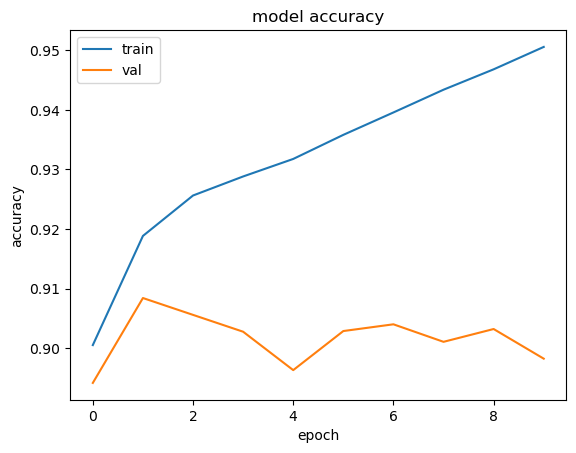

In [10]:
from matplotlib import pyplot as plt

plt.plot(history.history['binary_accuracy'])
plt.plot(history.history['val_binary_accuracy'])
plt.title('model accuracy')
plt.ylabel('accuracy')
plt.xlabel('epoch')
plt.legend(['train', 'val'], loc='upper left')
plt.show()

### Using Binary Focal loss

In [7]:
from keras.applications.resnet import ResNet50
from keras.models import Model
from keras.layers import Flatten, Dense, RandomRotation, RandomFlip, RandomZoom

# passar pra 3 canais
# incluir uma camada que faça a classificacao
# flatten
# densa
# classificacao

base_model = ResNet50(include_top=False, weights='imagenet', input_shape=(y, x, 3))
for layer in base_model.layers:
    layer.trainable = False
    
x = base_model.output
# x = RandomFlip("horizontal")(x)
# x = RandomZoom(0.2)(x)
# x = RandomRotation(0.2)(x)
x = Flatten()(x)
x = Dense(1024, activation='relu')(x)  
predictions = Dense(1, activation='sigmoid')(x)  

# Creating model combining the base of ResNet50 and the new custom layers
model = Model(inputs=base_model.input, outputs=predictions)

# Visualizing the network architecture
# model.summary()

In [8]:
tf.keras.metrics.BinaryAccuracy(
    name="binary_accuracy", dtype=None, threshold=0.5
)

In [9]:
model.compile(optimizer='adam', loss=tf.keras.losses.BinaryFocalCrossentropy(gamma=2.0), metrics=[tf.keras.metrics.BinaryAccuracy()])
history = model.fit(train_data_3, train_labels_tensor, epochs=10, batch_size=64, validation_split=0.2)

Epoch 1/10
553/553 [==============================] - 46s 73ms/step - loss: 0.6083 - binary_accuracy: 0.8857 - val_loss: 0.1479 - val_binary_accuracy: 0.8912
Epoch 2/10
553/553 [==============================] - 40s 72ms/step - loss: 0.0493 - binary_accuracy: 0.9199 - val_loss: 0.0577 - val_binary_accuracy: 0.9088
Epoch 3/10
553/553 [==============================] - 40s 71ms/step - loss: 0.0407 - binary_accuracy: 0.9296 - val_loss: 0.1395 - val_binary_accuracy: 0.8918
Epoch 4/10
553/553 [==============================] - 40s 72ms/step - loss: 0.0387 - binary_accuracy: 0.9324 - val_loss: 0.0647 - val_binary_accuracy: 0.9039
Epoch 5/10
553/553 [==============================] - 40s 72ms/step - loss: 0.0368 - binary_accuracy: 0.9367 - val_loss: 0.0647 - val_binary_accuracy: 0.8890
Epoch 6/10
553/553 [==============================] - 40s 72ms/step - loss: 0.0359 - binary_accuracy: 0.9360 - val_loss: 0.0752 - val_binary_accuracy: 0.9016
Epoch 7/10
553/553 [==============================] 

In [10]:
y_pred = model.predict(test_data_3)

346/346 [==============================] - 10s 26ms/step


In [11]:
a= np.rint(y_pred)

unique, counts = np.unique(a, return_counts=True)

dict(zip(unique, counts))

{0.0: 1764, 1.0: 9290}

In [12]:
# calculate the balanced accuracy
from sklearn.metrics import balanced_accuracy_score
from sklearn.metrics import classification_report
from sklearn.metrics import confusion_matrix

print(balanced_accuracy_score(test_labels_tensor, np.rint(y_pred)))
print("Confusion Matrix: \n" +  str(confusion_matrix(test_labels_tensor, np.rint(y_pred))))
print(classification_report(test_labels_tensor, np.rint(y_pred)))

0.7930292747952842
Confusion Matrix: 
[[ 832  390]
 [ 932 8900]]
              precision    recall  f1-score   support

           0       0.47      0.68      0.56      1222
           1       0.96      0.91      0.93      9832

    accuracy                           0.88     11054
   macro avg       0.71      0.79      0.74     11054
weighted avg       0.90      0.88      0.89     11054



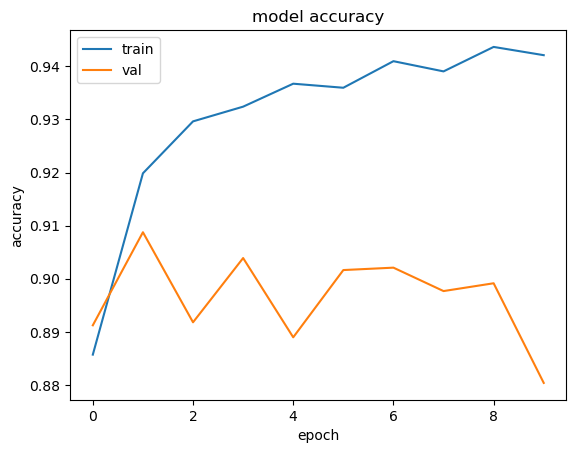

In [13]:
from matplotlib import pyplot as plt

plt.plot(history.history['binary_accuracy'])
plt.plot(history.history['val_binary_accuracy'])
plt.title('model accuracy')
plt.ylabel('accuracy')
plt.xlabel('epoch')
plt.legend(['train', 'val'], loc='upper left')
plt.show()

### Using Balanced Classes

In [31]:
import random

data = []
labels = []
random.seed(42)

# load the real data and their labels
photos_names = os.listdir(real_data)
for name in photos_names:
    data.append(cv.imread(os.path.join(real_data ,name) ,cv.IMREAD_GRAYSCALE))
    labels.append(0)

# load the altered data and their labels
dirs = ["Altered-Easy" ,"Altered-Hard" ,"Altered-Medium"]
limit = int((len(data)*1.2)/len(dirs))
for folder in dirs:
    dir_list = os.listdir(os.path.join(altered_data ,folder))
    photos_names = random.choices(population=dir_list, k=limit)
    for name in photos_names:
        data.append(cv.imread(os.path.join(altered_data ,folder ,name) ,cv.IMREAD_GRAYSCALE))
        labels.append(1)


In [32]:
x = 96
y = 103

In [33]:
# resizeing all the data to 103X96
for i,image in enumerate(data):
    data[i] = cv.resize(image ,(x,y))
    
data = np.stack(data).reshape(-1 ,y ,x ,1)
labels = np.stack(labels).reshape(-1 ,1)

In [34]:
train_data, test_data, train_labels, test_labels  = train_test_split(data, labels, test_size=0.2, random_state=42)

In [35]:
# converting numpy arrays to tensors
train_data_tensor = tf.convert_to_tensor(train_data, dtype=tf.float16)
test_data_tensor = tf.convert_to_tensor(test_data, dtype=tf.float16)
train_labels_tensor = tf.convert_to_tensor(train_labels, dtype=tf.int16)
test_labels_tensor = tf.convert_to_tensor(test_labels, dtype=tf.int16)

# converting to 3 channels
train_data_3 = tf.image.grayscale_to_rgb(train_data_tensor)
test_data_3 = tf.image.grayscale_to_rgb(test_data_tensor)

In [36]:
from keras.applications.resnet import ResNet50
from keras.models import Model
from keras.layers import Flatten, Dense, RandomRotation, RandomFlip, RandomZoom

# passar pra 3 canais
# incluir uma camada que faça a classificacao
# flatten
# densa
# classificacao

base_model = ResNet50(include_top=False, weights='imagenet', input_shape=(y, x, 3))
for layer in base_model.layers:
    layer.trainable = False
    
x = base_model.output
# x = RandomFlip("horizontal")(x)
# x = RandomZoom(0.2)(x)
# x = RandomRotation(0.2)(x)
x = Flatten()(x)
x = Dense(1024, activation='relu')(x)  
predictions = Dense(1, activation='sigmoid')(x)  

# Creating model combining the base of ResNet50 and the new custom layers
model = Model(inputs=base_model.input, outputs=predictions)

# Visualizing the network architecture
# model.summary()

In [37]:
tf.keras.metrics.BinaryAccuracy(
    name="binary_accuracy", dtype=None, threshold=0.5
)

model.compile(optimizer='adam', loss=tf.keras.losses.BinaryFocalCrossentropy(gamma=2.0), metrics=[tf.keras.metrics.BinaryAccuracy()])
history = model.fit(train_data_3, train_labels_tensor, epochs=10, batch_size=32, validation_split=0.2)

Epoch 1/10
264/264 [==============================] - 13s 40ms/step - loss: 1.4094 - binary_accuracy: 0.7984 - val_loss: 0.2411 - val_binary_accuracy: 0.7618
Epoch 2/10
264/264 [==============================] - 10s 37ms/step - loss: 0.1223 - binary_accuracy: 0.8632 - val_loss: 0.1497 - val_binary_accuracy: 0.8068
Epoch 3/10
264/264 [==============================] - 10s 37ms/step - loss: 0.0704 - binary_accuracy: 0.8996 - val_loss: 0.0879 - val_binary_accuracy: 0.8679
Epoch 4/10
264/264 [==============================] - 10s 39ms/step - loss: 0.0557 - binary_accuracy: 0.9148 - val_loss: 0.0821 - val_binary_accuracy: 0.8759
Epoch 5/10
264/264 [==============================] - 10s 38ms/step - loss: 0.0485 - binary_accuracy: 0.9242 - val_loss: 0.1270 - val_binary_accuracy: 0.8191
Epoch 6/10
264/264 [==============================] - 10s 36ms/step - loss: 0.0458 - binary_accuracy: 0.9278 - val_loss: 0.0876 - val_binary_accuracy: 0.8807
Epoch 7/10
264/264 [==============================] 

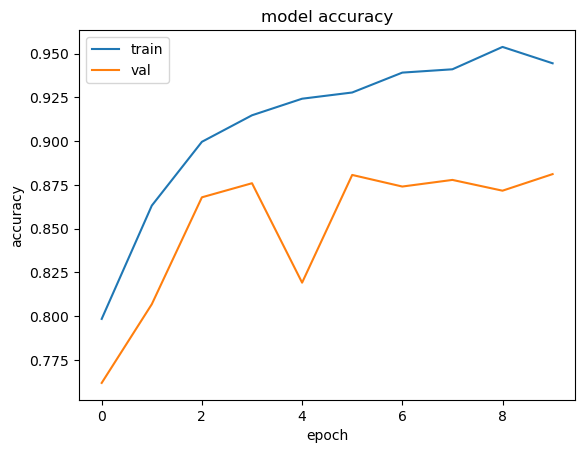

In [38]:
from matplotlib import pyplot as plt

plt.plot(history.history['binary_accuracy'])
plt.plot(history.history['val_binary_accuracy'])
plt.title('model accuracy')
plt.ylabel('accuracy')
plt.xlabel('epoch')
plt.legend(['train', 'val'], loc='upper left')
plt.show()

In [39]:
from sklearn.metrics import balanced_accuracy_score
from sklearn.metrics import confusion_matrix
from sklearn.metrics import classification_report

y_pred = model.predict(test_data_3)

print("Balanced Accuracy: " +  str(balanced_accuracy_score(test_labels_tensor, np.rint(y_pred))))
print("Confusion Matrix: \n" +  str(confusion_matrix(test_labels_tensor, np.rint(y_pred))))
print(classification_report(test_labels_tensor, np.rint(y_pred)))

83/83 [==============================] - 3s 28ms/step
Balanced Accuracy: 0.8692200007989481
Confusion Matrix: 
[[1010  187]
 [ 152 1291]]
              precision    recall  f1-score   support

           0       0.87      0.84      0.86      1197
           1       0.87      0.89      0.88      1443

    accuracy                           0.87      2640
   macro avg       0.87      0.87      0.87      2640
weighted avg       0.87      0.87      0.87      2640



In [20]:
model.save('socoF.h5') 